# SETUP

In [1]:
# !pip install dezerogym

In [2]:
# utility functions (common functions)
def argmax(xs):
    idxes = [i for i, x in enumerate(xs) if x == max(xs)]
    if len(idxes) == 1:
        return idxes[0]
    elif len(idxes) == 0:
        return np.random.choice(len(xs))
    selected = np.random.choice(idxes)
    return selected

In [3]:
def greedy_probs(Q, state, epsilon=0, action_size=4):
    qs = [Q[(state, action)] for action in range(action_size)]
    max_action = argmax(qs)  # OR np.argmax(qs)
    base_prob = epsilon / action_size
    action_probs = {action: base_prob for action in range(action_size)}  #{0: ε/4, 1: ε/4, 2: ε/4, 3: ε/4}
    action_probs[max_action] += (1 - epsilon)
    return action_probs

# td_eval.py

In [4]:
from collections import defaultdict
import numpy as np
from dezerogym.gridworld import GridWorld

In [5]:
class TdAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.01
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.V = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def eval(self, state, reward, next_state, done):
        next_V = 0 if done else self.V[next_state]
        target = reward + self.gamma * next_V
        self.V[state] += (target - self.V[state]) * self.alpha


In [6]:
env = GridWorld()
agent = TdAgent()

In [7]:
episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.eval(state, reward, next_state, done)
        if done:
            break
        state = next_state

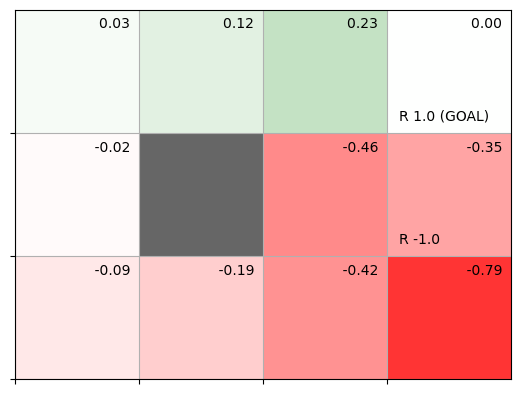

In [8]:
env.render_v(agent.V)

# sarsa.py

In [9]:
from collections import deque

In [10]:
class SarsaAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.pi[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]
        next_q = 0 if done else self.Q[next_state, next_action]

        target = reward + self.gamma * next_q
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha
        self.pi[state] = greedy_probs(self.Q, state, self.epsilon)


In [11]:
env = GridWorld()
agent = SarsaAgent()

In [12]:
episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

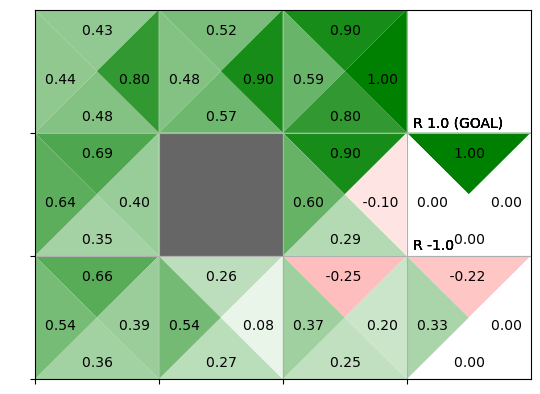

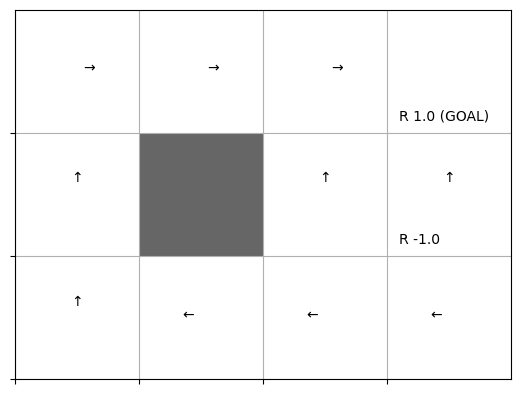

In [13]:
env.render_q(agent.Q)

# ch06/sarsa_off_policy.py

In [14]:
class SarsaOffPolicyAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)
        self.memory = deque(maxlen=2)

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def reset(self):
        self.memory.clear()

    def update(self, state, action, reward, done):
        self.memory.append((state, action, reward, done))
        if len(self.memory) < 2:
            return

        state, action, reward, done = self.memory[0]
        next_state, next_action, _, _ = self.memory[1]

        if done:
            next_q = 0
            rho = 1
        else:
            next_q = self.Q[next_state, next_action]
            rho = self.pi[next_state][next_action] / self.b[next_state][next_action]

        target = rho * (reward + self.gamma * next_q)
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.pi[state] = greedy_probs(self.Q, state, 0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)


In [15]:
env = GridWorld()
agent = SarsaOffPolicyAgent()

In [16]:
episodes = 10000
for episode in range(episodes):
    state = env.reset()
    agent.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, done)

        if done:
            agent.update(next_state, None, None, None)
            break
        state = next_state

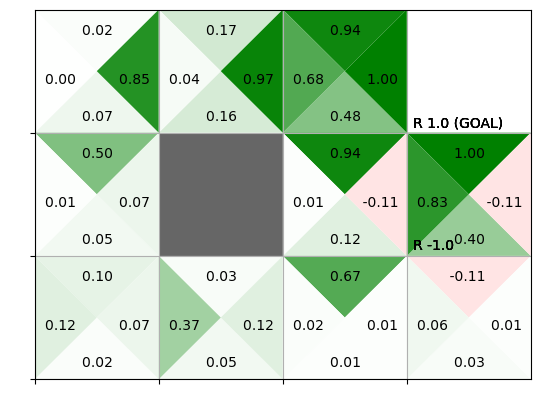

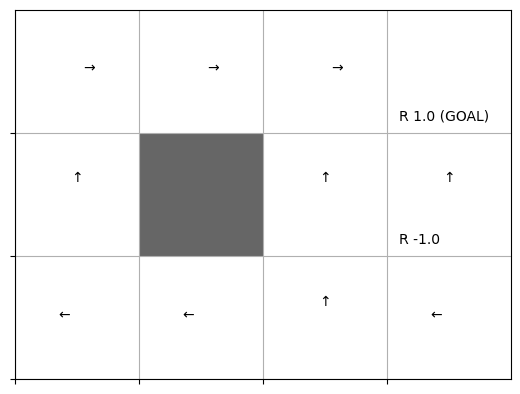

In [17]:
env.render_q(agent.Q)

# q_learning.py

In [18]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4

        random_actions = {0: 0.25, 1: 0.25, 2: 0.25, 3: 0.25}
        self.pi = defaultdict(lambda: random_actions)
        self.b = defaultdict(lambda: random_actions)
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        action_probs = self.b[state]
        actions = list(action_probs.keys())
        probs = list(action_probs.values())
        return np.random.choice(actions, p=probs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha

        self.pi[state] = greedy_probs(self.Q, state, epsilon=0)
        self.b[state] = greedy_probs(self.Q, state, self.epsilon)


In [19]:
env = GridWorld()
agent = QLearningAgent()

In [20]:
episodes = 10000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state

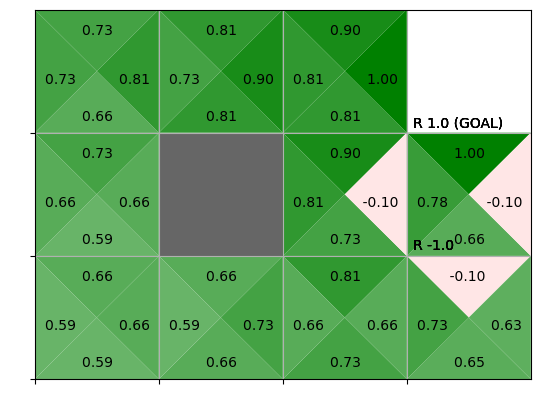

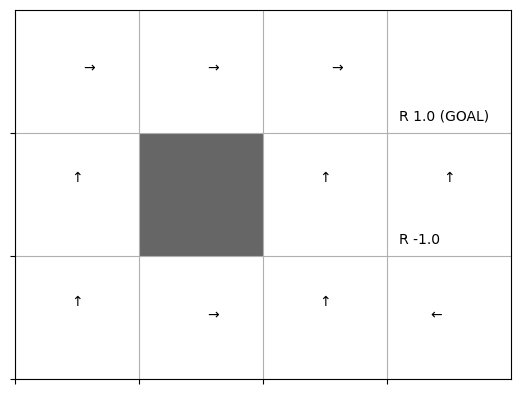

In [21]:
env.render_q(agent.Q)

# q_learning_simple.py

In [22]:
class QLearningAgent:
    def __init__(self):
        self.gamma = 0.9
        self.alpha = 0.8
        self.epsilon = 0.1
        self.action_size = 4
        self.Q = defaultdict(lambda: 0)

    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return np.random.choice(self.action_size)
        else:
            qs = [self.Q[state, a] for a in range(self.action_size)]
            return np.argmax(qs)

    def update(self, state, action, reward, next_state, done):
        if done:
            next_q_max = 0
        else:
            next_qs = [self.Q[next_state, a] for a in range(self.action_size)]
            next_q_max = max(next_qs)

        target = reward + self.gamma * next_q_max
        self.Q[state, action] += (target - self.Q[state, action]) * self.alpha


In [23]:
env = GridWorld()
agent = QLearningAgent()

In [24]:
episodes = 1000
for episode in range(episodes):
    state = env.reset()

    while True:
        action = agent.get_action(state)
        next_state, reward, done = env.step(action)

        agent.update(state, action, reward, next_state, done)
        if done:
            break
        state = next_state

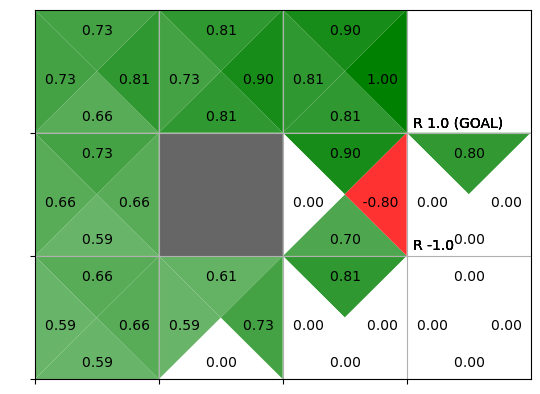

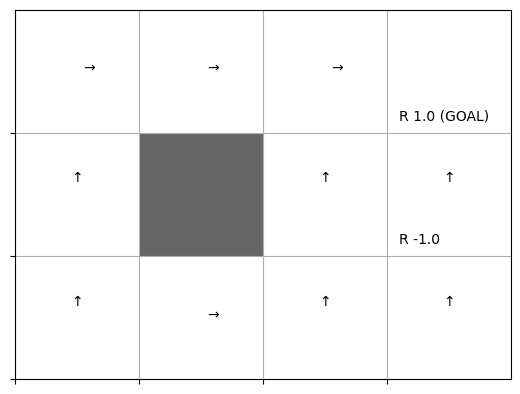

In [25]:
env.render_q(agent.Q)